Для сегментации будет использован YOLO, так как он наиболее прост в обращении.
Поскольку он не принимает изображения с маской для обучения, их надо преобразовать в контуры.
Для работы были использованы следующие инструменты:
<h4>binary-to-coco-json-converter</h4>
Это вариация другого инструмента "image-to-coco-json-converter". От предшественника он отличается тем, что работает с чёрно-белыми масками, а значит для генерации полигонов использует алгоритм <i>findContours</i> из библиотеки <i>cv2</i>. Инструмент применяет этот алгоритм на всех масках, который найдёт в заданной папке, а затем собирает их в JSON-файл формата COCO.

In [9]:
!git clone https://github.com/brunobelloni/binary-to-coco-json-converter.git

Клонирование в «binary-to-coco-json-converter»…
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 147 (delta 38), reused 145 (delta 36), pack-reused 0
Получение объектов: 100% (147/147), 5.60 МиБ | 8.25 МиБ/с, готово.
Определение изменений: 100% (38/38), готово.


После выполнения JSON-аннотации были успешно сгенерированы.

In [42]:
import torchvision
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, train=True):
        ann_file = os.path.join(img_folder, "../train.json" if train else "../val.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        img, target = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target

In [43]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("hustvl/yolos-small", size=512, max_size=864)

data_path = '/home/student1/PatternsDetection/Segmentation/20230904_segm_rat_OFT_gray_back/20230904_segm_rat_OFT_gray_back/'
train_dataset = CocoDetection(img_folder= data_path + 'train/images/', feature_extractor=feature_extractor)
val_dataset = CocoDetection(img_folder=data_path + 'val/images/', feature_extractor=feature_extractor, train=False)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


/home/student1/miniconda3/envs/conda-env/lib/python3.9/site-packages/transformers/models/yolos/feature_extraction_yolos.py:38: FutureWarning: The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.
  warnings.warn(


In [44]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 564
Number of validation examples: 10


Image: 489


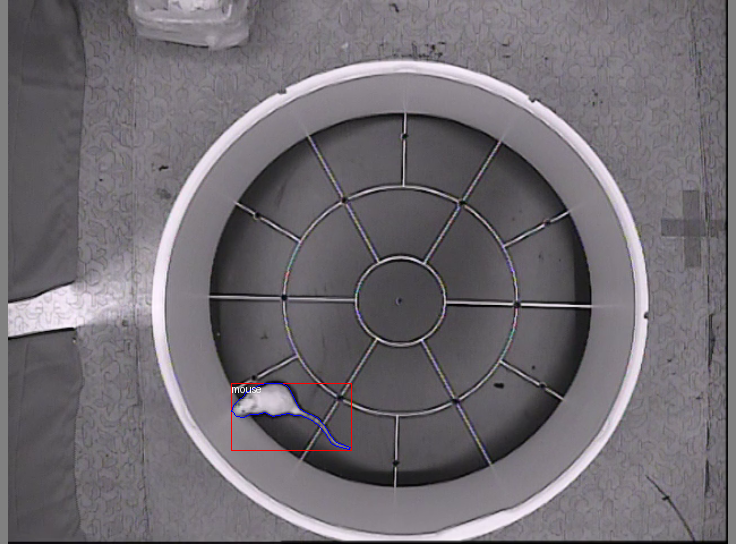

In [76]:
import numpy as np
import os
from PIL import Image, ImageDraw

# используя
image_ids = train_dataset.coco.getImgIds()

image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image: {}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(data_path + 'train/images/', image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  mask = annotation['segmentation']
  polygons = []
  for i in range (0, len(mask[0]), 2):
    polygons.append((mask[0][i], mask[0][i+1]))
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.polygon(polygons, outline='blue', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

YOLO не работает с JSON-аннотациями, но он работает с labels в формате txt, которые можно сгенерировать с помощью следующего инструмента:
<h4>JSON2YOLO</h4>

In [32]:
!git clone https://github.com/ultralytics/JSON2YOLO

Клонирование в «JSON2YOLO»…


/home/student1/miniconda3/envs/conda-env/lib/python3.9/pty.py:85: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


remote: Enumerating objects: 358, done.
remote: Counting objects: 100% (222/222), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 358 (delta 205), reused 170 (delta 169), pack-reused 136
Получение объектов: 100% (358/358), 97.06 КиБ | 375.00 КиБ/с, готово.
Определение изменений: 100% (221/221), готово.


In [33]:
%cd JSON2YOLO

/home/student1/PatternsDetection/Segmentation/20230904_segm_rat_OFT_gray_back/JSON2YOLO


In [39]:
from JSON2YOLO.general_json2yolo import convert_coco_json

test_path = '../20230904_segm_rat_OFT_gray_back/val_images'
train_path = '../20230904_segm_rat_OFT_gray_back/train_images'

convert_coco_json(test_path, use_segments=True)

Annotations /home/student1/PatternsDetection/Segmentation/20230904_segm_rat_OFT_gray_back/20230904_segm_rat_OFT_gray_back/val_images/val.json: 100%|██████████| 10/10 [00:00<00:00, 2189.55it/s]


После использования инструмента был вручную создан файл .yaml, в котором были указаны директории, в которых находятся изображения, а также был указан список классов. Класс только один: мышь (mouse). Полученный датасет подходит для обучения.
<h4>YOLO</h4>

In [78]:
%cd ..

/home/student1/PatternsDetection/Segmentation/20230904_segm_rat_OFT_gray_back


In [7]:
!yolo task=segment mode=train model=yolov8m-seg.pt imgsz=520 data='20230904_segm_rat_OFT_gray_back/mouses.yaml' epochs=100 batch=-1 name=yolov8m-seg exist_ok=True amp=False device=0

New https://pypi.org/project/ultralytics/8.2.4 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.2 🚀 Python-3.9.18 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3070, 7944MiB)
engine/trainer: task=segment, mode=train, model=yolov8m-seg.pt, data=20230904_segm_rat_OFT_gray_back/mouses.yaml, epochs=100, time=None, patience=100, batch=-1, imgsz=520, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=yolov8m-seg, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=F

Метрика:

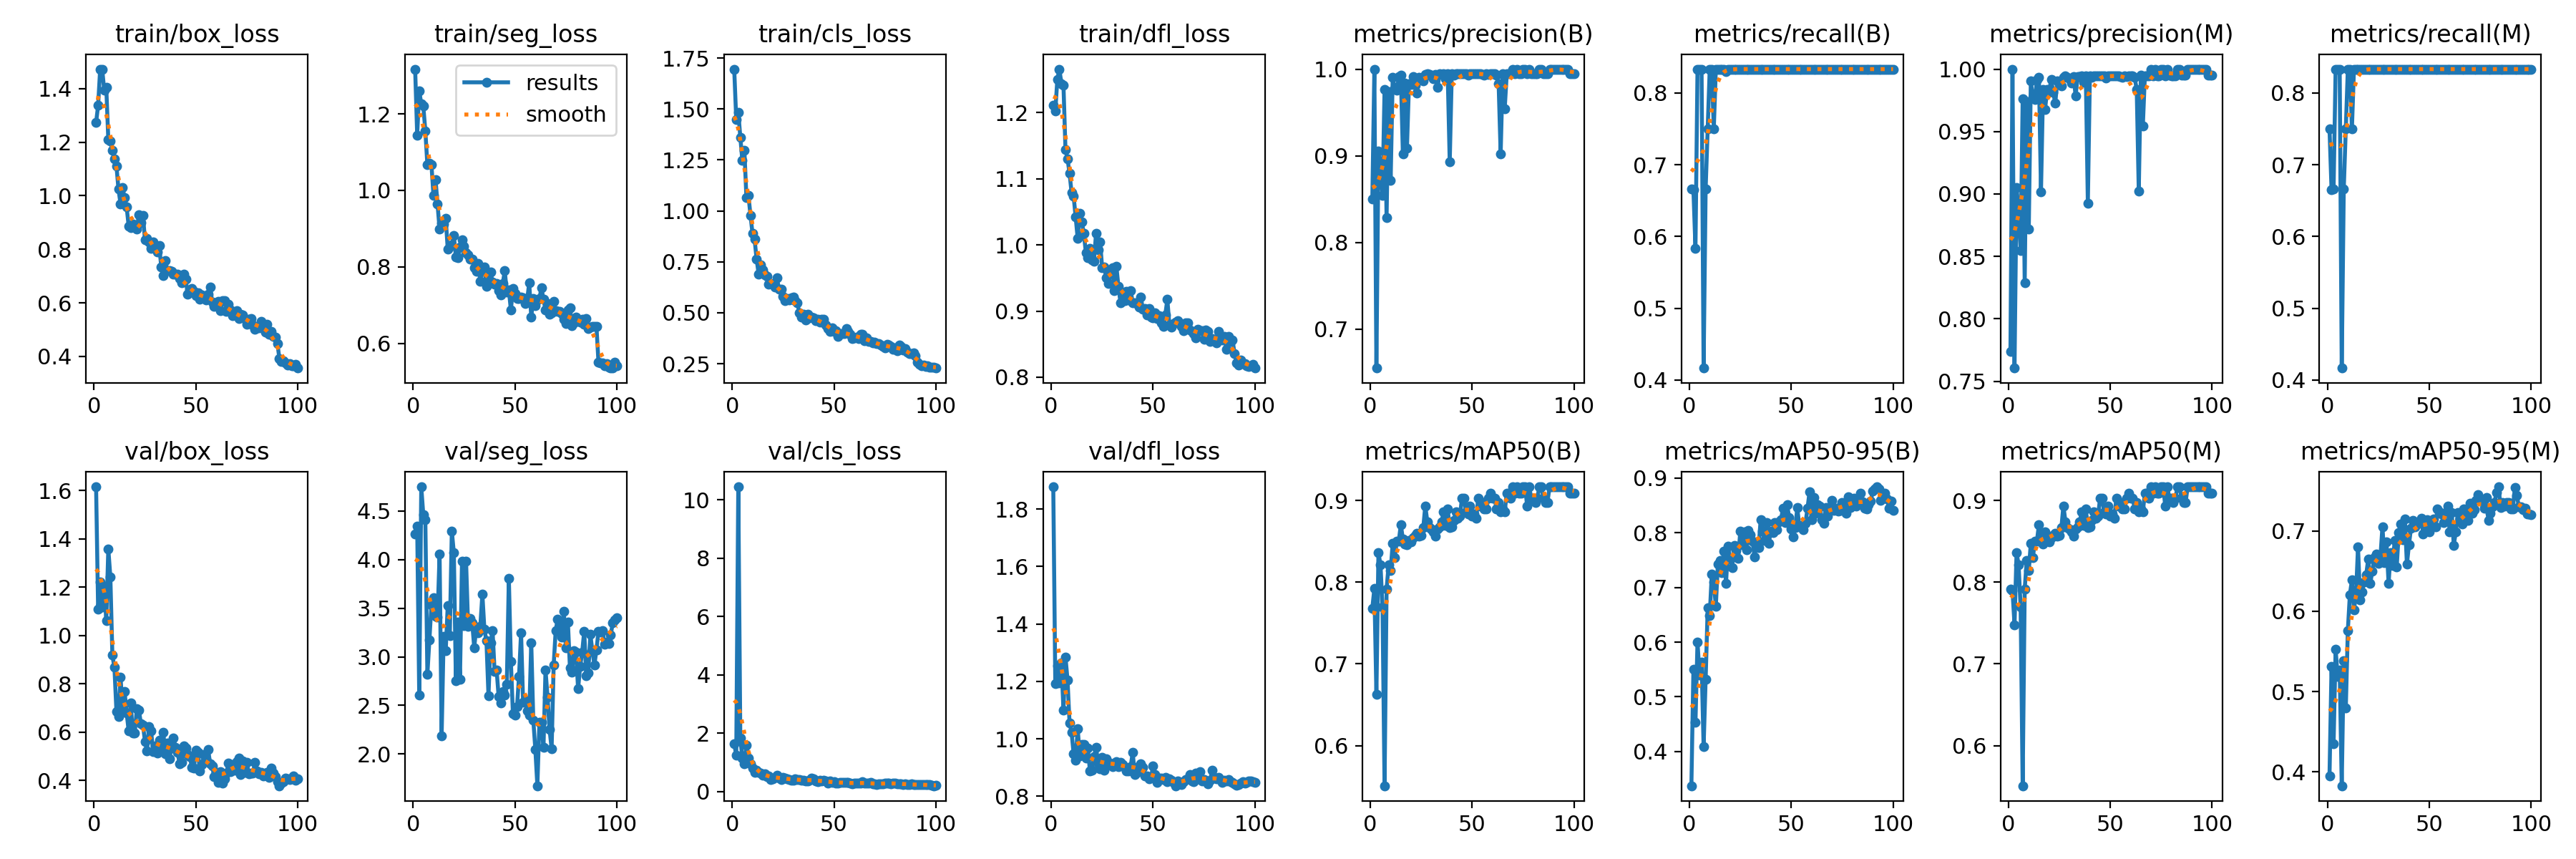

In [39]:
image = Image.open(os.path.join('runs/segment/yolov8m-seg/results.png'))
image

Сегментация видео по обученной модели:

In [89]:
!yolo model='runs/segment/yolov8m-seg/weights/best.pt' mode=predict source='OFT_rat10_intact$000092&03_.m4v' name=yolov8m_seg_video exist_ok=True

Ultralytics YOLOv8.2.2 🚀 Python-3.9.18 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3070, 7944MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs

video 1/1 (frame 1/4499) /home/student1/PatternsDetection/Segmentation/20230904_segm_rat_OFT_gray_back/OFT_rat10_intact$000092&03_.m4v: 544x544 1 mouse, 10.0ms
video 1/1 (frame 2/4499) /home/student1/PatternsDetection/Segmentation/20230904_segm_rat_OFT_gray_back/OFT_rat10_intact$000092&03_.m4v: 544x544 1 mouse, 10.1ms
video 1/1 (frame 3/4499) /home/student1/PatternsDetection/Segmentation/20230904_segm_rat_OFT_gray_back/OFT_rat10_intact$000092&03_.m4v: 544x544 1 mouse, 10.0ms
video 1/1 (frame 4/4499) /home/student1/PatternsDetection/Segmentation/20230904_segm_rat_OFT_gray_back/OFT_rat10_intact$000092&03_.m4v: 544x544 1 mouse, 10.0ms
video 1/1 (frame 5/4499) /home/student1/PatternsDetection/Segmentation/20230904_segm_rat_OFT_gray_back/OFT_rat10_intact$000092&03_.m4v: 544x544 1 mouse, 10.0ms
video 1/1 (f

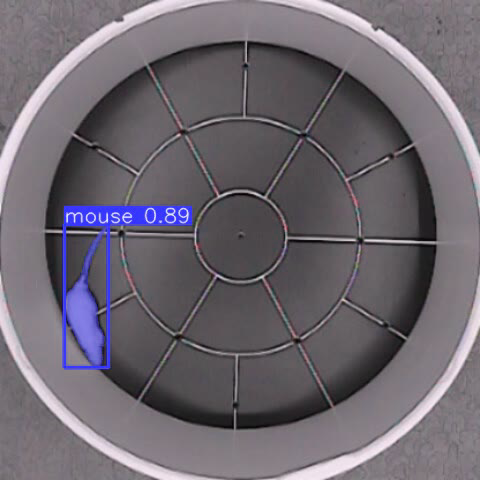

In [46]:
import cv2

vidcap = cv2.VideoCapture('runs/segment/yolov8m_seg_video/OFT_rat01_intact$000128&03_.avi')
vidcap.set(cv2.CAP_PROP_POS_MSEC,21500)
success,image = vidcap.read()
img = Image.fromarray(image)
img

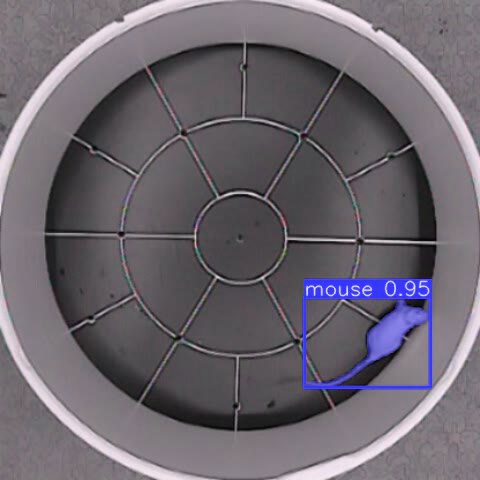

In [90]:
vidcap = cv2.VideoCapture('runs/segment/yolov8m_seg_video/OFT_rat10_intact$000092&03_.avi')
vidcap.set(cv2.CAP_PROP_POS_MSEC,48200)
success,image = vidcap.read()
img = Image.fromarray(image)
img

При генерации датасета функция "findContours" разделила несколько масок на две части: хвост и тело. Из-за присутствия этих "бракованных" масок в преобразованном датасете нейросетка иногда сегментирует хвост и саму мышь отдельно. Также несколько раз железные прутья на платформе были классифицированы как мышиный хвост.

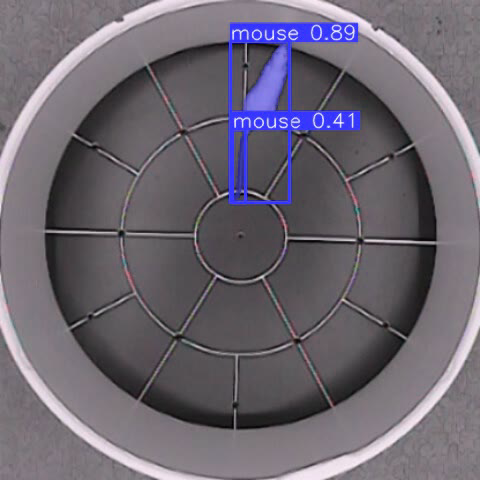

In [52]:
vidcap = cv2.VideoCapture('runs/segment/yolov8m_seg_video/OFT_rat01_intact$000128&03_.avi')
vidcap.set(cv2.CAP_PROP_POS_MSEC,1500)
success,image = vidcap.read()
img = Image.fromarray(image)
img

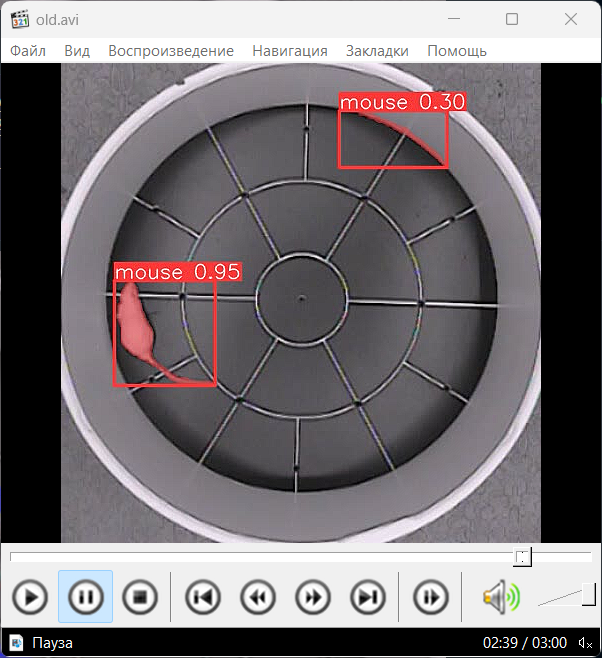

In [87]:
image = Image.open(os.path.join('runs/segment/yolov8m_seg_video/screenshot.png'))
image

Далее я уберу из датасета весь брак чтобы такое не повторялось.

In [33]:
import glob
import os

for file in glob.glob("20230904_segm_rat_OFT_gray_back/*/labels/*.txt"):
    with open(file, 'r') as fp:
        if len(fp.readlines()) > 1:
            filename = os.path.basename(file)[:-4]
            if file[32] == "t":
                splited = "train"
            else:
                splited = "val"
            print('Broken:', filename, splited)
            os.remove(f'20230904_segm_rat_OFT_gray_back/{splited}/labels/{filename}.txt')
            os.remove(f'20230904_segm_rat_OFT_gray_back/{splited}/images/{filename}.bmp')

Broken: OFT_TBI_10$000294&03_@000768 train
Broken: OFT_TBI_07$000373&03_@000296 train
Broken: OFT_rat03_intact$000010&03_@000055 train
Broken: OFT_TBI_10$000294&03_@000985 train
Broken: OFT_TBI_02$000304&03_@000343 train
Broken: OFT_rat01_intact$000090&03_@001883 train
Broken: OFT_control_06$000126&03_@001596 train
Broken: OFT_TBI_03$000343&03_@002082 train
Broken: OFT_TBI_04$000339&03_@001772 train
Broken: OFT_rat02_intact$000161&03_@000222 train
Broken: OFT_TBI_06$000180&03_@000666 train
Broken: OFT_TBI_06$000180&03_@001860 train
Broken: OFT_rat03_intact$000010&03_@000078 train
Broken: OFT_control_08$000141&03_@001800 train
Broken: OFT_rat01_intact$000090&03_@000254 train
Broken: OFT_rat06_intact@002486 train
Broken: OFT_rat08_intact@000972 train
Broken: OFT_TBI_06$000180&03_@002188 train
Broken: OFT_control_03$000141&03_@000994 train
Broken: OFT_control_04$000176&03_@004368 val
Broken: OFT_control_03$000141&03_@000030 val


Повторное обучение нейросети

In [34]:
!yolo task=segment mode=train model=yolov8m-seg.pt imgsz=520 data='20230904_segm_rat_OFT_gray_back/mouses.yaml' epochs=150 batch=-1 name=yolov8m-seg-retry exist_ok=True amp=False device=0

New https://pypi.org/project/ultralytics/8.2.4 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.2 🚀 Python-3.9.18 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3070, 7944MiB)
engine/trainer: task=segment, mode=train, model=yolov8m-seg.pt, data=20230904_segm_rat_OFT_gray_back/mouses.yaml, epochs=150, time=None, patience=100, batch=-1, imgsz=520, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=yolov8m-seg-retry, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_m

Метрика:

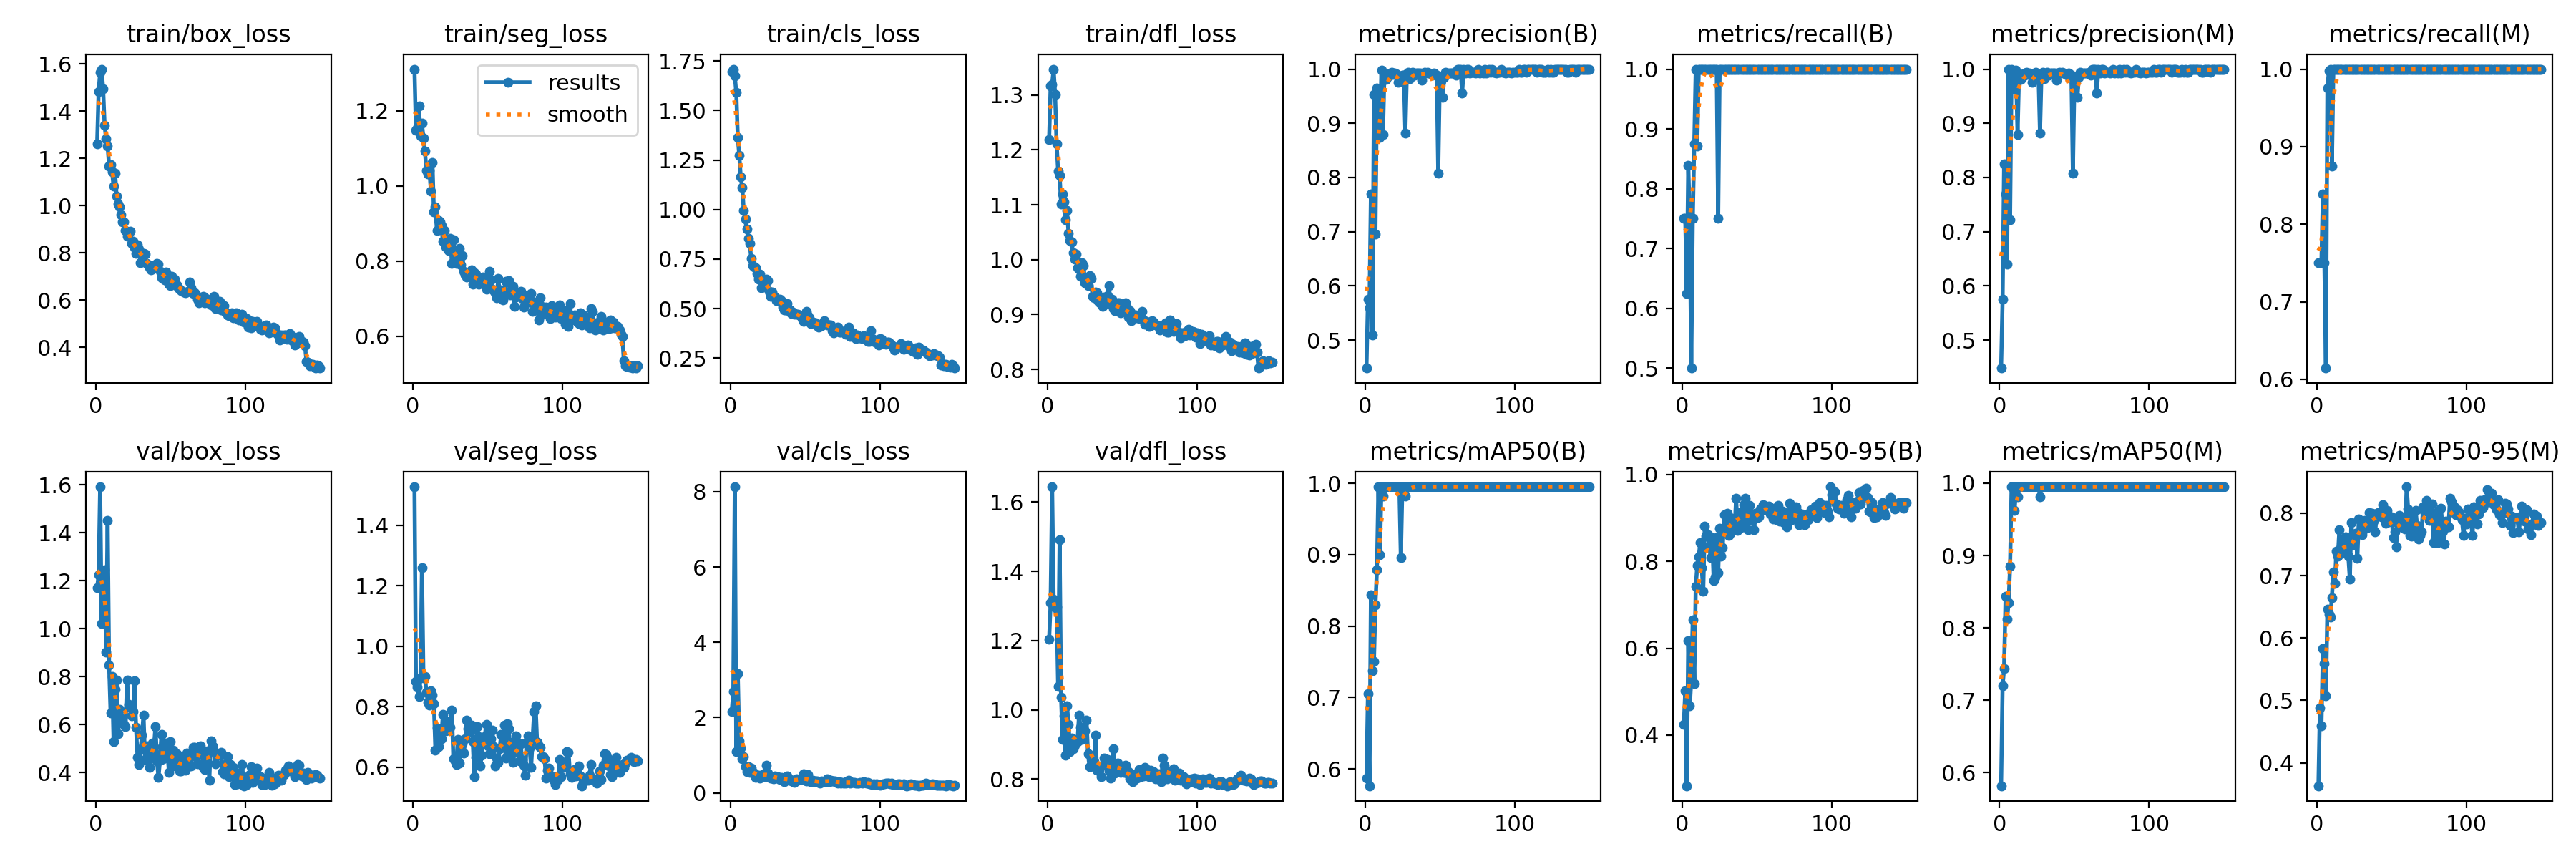

In [38]:
image = Image.open(os.path.join('runs/segment/yolov8m-seg-retry/results.png'))
image

Сегментация видео:

In [36]:
!yolo model='runs/segment/yolov8m-seg-retry/weights/best.pt' mode=predict source='OFT_rat10_intact$000092&03_.m4v' name=yolov8m_seg-video-retry exist_ok=True

Ultralytics YOLOv8.2.2 🚀 Python-3.9.18 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3070, 7944MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs

video 1/1 (frame 1/4499) /home/student1/PatternsDetection/Segmentation/20230904_segm_rat_OFT_gray_back/OFT_rat10_intact$000092&03_.m4v: 544x544 1 mouse, 10.1ms
video 1/1 (frame 2/4499) /home/student1/PatternsDetection/Segmentation/20230904_segm_rat_OFT_gray_back/OFT_rat10_intact$000092&03_.m4v: 544x544 1 mouse, 10.1ms
video 1/1 (frame 3/4499) /home/student1/PatternsDetection/Segmentation/20230904_segm_rat_OFT_gray_back/OFT_rat10_intact$000092&03_.m4v: 544x544 1 mouse, 10.1ms
video 1/1 (frame 4/4499) /home/student1/PatternsDetection/Segmentation/20230904_segm_rat_OFT_gray_back/OFT_rat10_intact$000092&03_.m4v: 544x544 1 mouse, 10.0ms
video 1/1 (frame 5/4499) /home/student1/PatternsDetection/Segmentation/20230904_segm_rat_OFT_gray_back/OFT_rat10_intact$000092&03_.m4v: 544x544 1 mouse, 10.0ms
video 1/1 (f

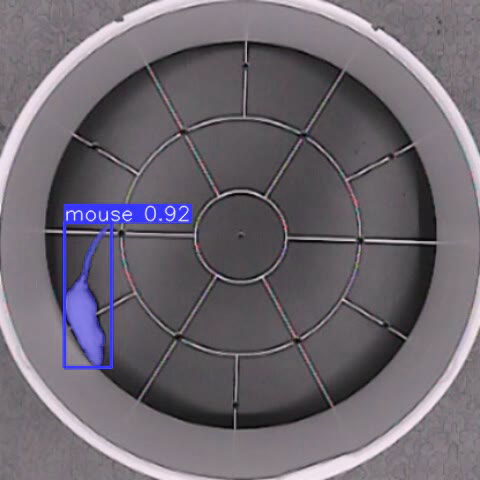

In [47]:
vidcap = cv2.VideoCapture('runs/segment/yolov8m_seg-video-retry/OFT_rat01_intact$000128&03_.avi')
vidcap.set(cv2.CAP_PROP_POS_MSEC,21500)
success,image = vidcap.read()
img = Image.fromarray(image)
img

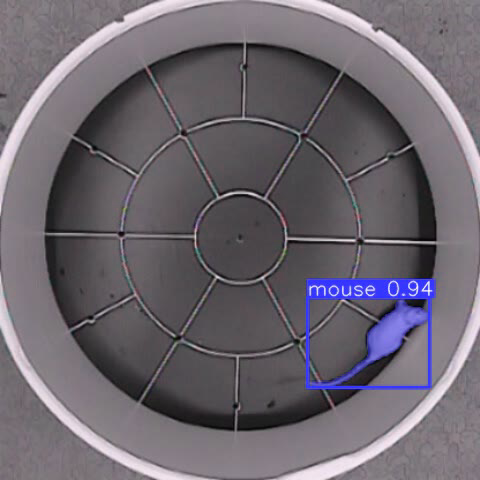

In [44]:
vidcap = cv2.VideoCapture('runs/segment/yolov8m_seg-video-retry/OFT_rat10_intact$000092&03_.avi')
vidcap.set(cv2.CAP_PROP_POS_MSEC,48200)
success,image = vidcap.read()
img = Image.fromarray(image)
img

Количество ошибочных распознаваний мышки как туловище и хвост отдельно значительно сократилось, однако не было полностью предотвращено. Тем не менее на данный момент сегментируется исключительно мышь, что уже лучше, чем было до этого.<br>
Предположительно, среди масок остался брак. По-хорошему, стоит вручную проверить все полученные полигоны, однако всего изображений в датасете 574, а я один и времени у меня мало. 